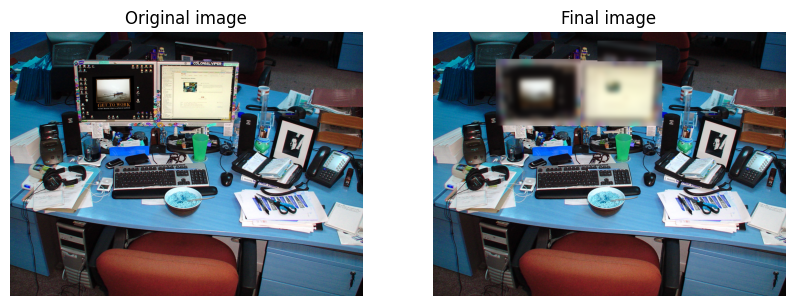

In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

from file_processing import *


model = YOLO("yolo12x.pt")
items_to_blur = [62, 63] # tv, laptop
blur_coefficient = 49
input_path = Path().parent / "tests" / "images" / "low_res.jpg"
original_high_res = cv2.imread(input_path)
blurred_low_res = original_high_res.copy()

def blur_function(roi):
    return cv2.GaussianBlur(roi, (blur_coefficient, blur_coefficient), 0)

results = model(blurred_low_res, verbose=False)

blur_items(results[0], items_to_blur, blurred_low_res, blur_function)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(original_high_res)
axes[0].set_title('Original image')
axes[0].axis('off')

axes[1].imshow(blurred_low_res)
axes[1].set_title('Final image')
axes[1].axis('off')

plt.show()

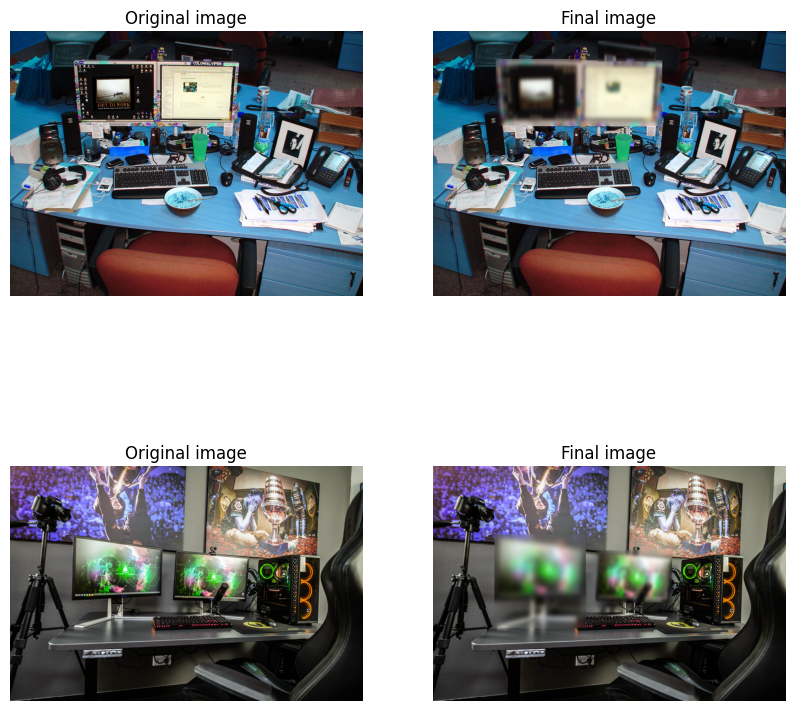

In [2]:
items_to_blur = [62, 63] # tv, laptop
blur_coefficient = 49
low_res_path = Path().parent / "tests" / "images" / "low_res.jpg"
high_res_path = Path().parent / "tests" / "images" / "high_res.jpg"
original_low_res = cv2.imread(low_res_path)
original_high_res = cv2.imread(high_res_path)
blurred_low_res = original_low_res.copy()
blurred_high_res = original_high_res.copy()

def blur_function(roi):
    blur_coefficient = 0.05 * 3
    h, w = roi.shape[:2]
    ksize = (int(h * blur_coefficient) | 1, int(w * blur_coefficient) | 1)
    return cv2.GaussianBlur(roi, ksize, 0)

results = model(blurred_low_res, verbose=False)
blur_items(results[0], items_to_blur, blurred_low_res, blur_function)

results = model(blurred_high_res, verbose=False)
blur_items(results[0], items_to_blur, blurred_high_res, blur_function)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0][0].imshow(original_low_res)
axes[0][0].set_title("Original image")
axes[0][0].axis("off")

axes[0][1].imshow(blurred_low_res)
axes[0][1].set_title("Final image")
axes[0][1].axis("off")

axes[1][0].imshow(original_high_res)
axes[1][0].set_title("Original image")
axes[1][0].axis("off")

axes[1][1].imshow(blurred_high_res)
axes[1][1].set_title("Final image")
axes[1][1].axis("off")

plt.show()

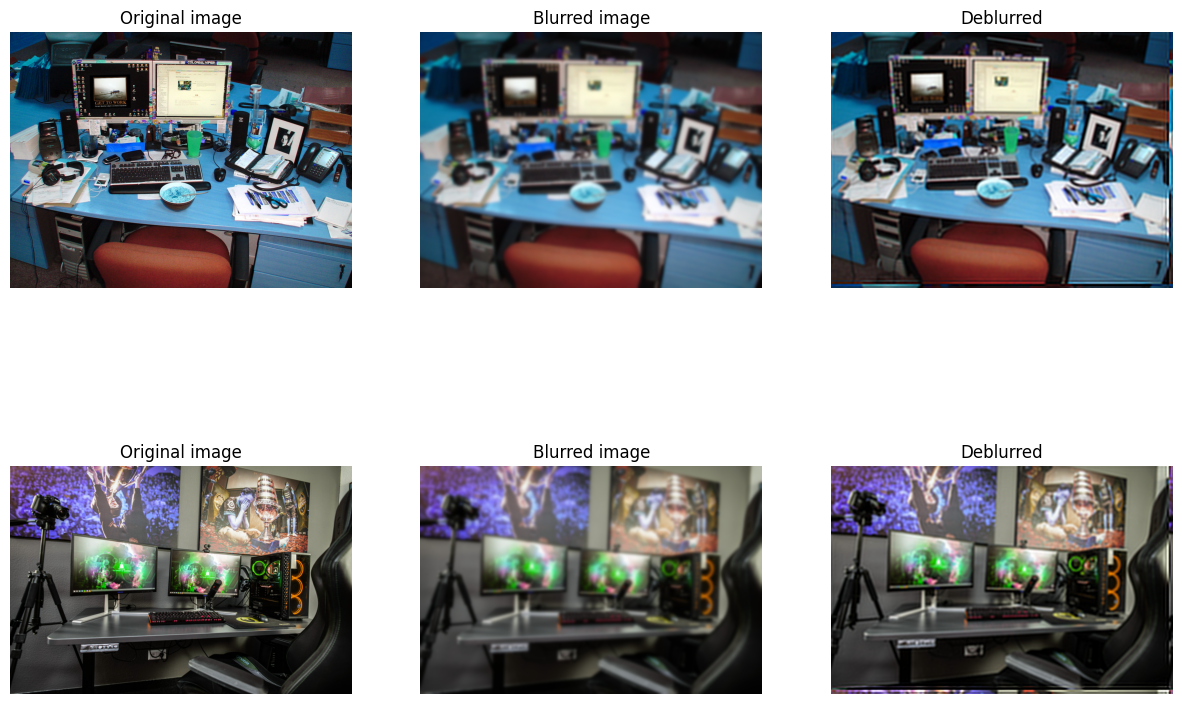

In [3]:
blur_coefficient = 5
low_res_path = Path().parent / "tests" / "images" / "low_res.jpg"
high_res_path = Path().parent / "tests" / "images" / "high_res.jpg"
original_low_res = cv2.imread(low_res_path)
original_high_res = cv2.imread(high_res_path)
blurred_low_res = original_low_res.copy()
blurred_high_res = original_high_res.copy()


#
def gaussian_kernel(size, sigma):
    k = cv2.getGaussianKernel(size, sigma)
    kernel = np.outer(k, k)
    return kernel


def wiener_deblur(blurred, kernel, K=0.01):
    deblurred = np.zeros_like(blurred)

    for i in range(3):  # Loop through R, G, B channels
        blurred_fft = np.fft.fft2(blurred[:, :, i])
        kernel_fft = np.fft.fft2(kernel, s=blurred[:, :, i].shape)

        # Wiener deconvolution formula: (H*) / (|H|^2 + K)
        kernel_fft_conj = np.conj(kernel_fft)
        deblurred_fft = (blurred_fft * kernel_fft_conj) / (np.abs(kernel_fft) ** 2 + K)

        # Inverse FFT and clip pixel values
        deblurred[:, :, i] = np.clip(np.fft.ifft2(deblurred_fft).real, 0, 255)

    return deblurred.astype(np.uint8)


def calculate_sigma(ksize):
    return 0.3 * ((ksize - 1) * 0.5 - 1) + 0.8


def get_ksize(image, blur_coefficient):
    w = image.shape[1]
    ksize = int(w * 0.005 * blur_coefficient) | 1
    return ksize


# Low resolution
ksize = get_ksize(original_low_res, blur_coefficient)
sigma = calculate_sigma(ksize)
kernel = gaussian_kernel(ksize, sigma)
blurred_low_res = cv2.GaussianBlur(original_low_res, (ksize, ksize), 0)
deblurred_low_res = wiener_deblur(blurred_low_res, kernel)

# High resolution
ksize = get_ksize(original_high_res, blur_coefficient)
sigma = calculate_sigma(ksize)
kernel = gaussian_kernel(ksize, sigma)
blurred_high_res = cv2.GaussianBlur(original_high_res, (ksize, ksize), 0)
deblurred_high_res = wiener_deblur(blurred_high_res, kernel)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

cv2.imwrite(low_res_path.parent / "blurred_low_res.jpg", blurred_low_res)
cv2.imwrite(low_res_path.parent / "deblurred_low_res.jpg", deblurred_low_res)
cv2.imwrite(low_res_path.parent / "blurred_high_res.jpg", blurred_high_res)
cv2.imwrite(low_res_path.parent / "deblurred_high_res.jpg", deblurred_high_res)

axes[0][0].imshow(original_low_res)
axes[0][0].set_title("Original image")
axes[0][0].axis("off")

axes[0][1].imshow(blurred_low_res)
axes[0][1].set_title("Blurred image")
axes[0][1].axis("off")

axes[0][2].imshow(deblurred_low_res)
axes[0][2].set_title("Deblurred")
axes[0][2].axis("off")

axes[1][0].imshow(original_high_res)
axes[1][0].set_title("Original image")
axes[1][0].axis("off")

axes[1][1].imshow(blurred_high_res)
axes[1][1].set_title("Blurred image")
axes[1][1].axis("off")

axes[1][2].imshow(deblurred_high_res)
axes[1][2].set_title("Deblurred")
axes[1][2].axis("off")

plt.show()

In [4]:
names = {
    0: "person",
    1: "bicycle",
    2: "car",
    3: "motorcycle",
    4: "airplane",
    5: "bus",
    6: "train",
    7: "truck",
    8: "boat",
    9: "traffic light",
    10: "fire hydrant",
    11: "stop sign",
    12: "parking meter",
    13: "bench",
    14: "bird",
    15: "cat",
    16: "dog",
    17: "horse",
    18: "sheep",
    19: "cow",
    20: "elephant",
    21: "bear",
    22: "zebra",
    23: "giraffe",
    24: "backpack",
    25: "umbrella",
    26: "handbag",
    27: "tie",
    28: "suitcase",
    29: "frisbee",
    30: "skis",
    31: "snowboard",
    32: "sports ball",
    33: "kite",
    34: "baseball bat",
    35: "baseball glove",
    36: "skateboard",
    37: "surfboard",
    38: "tennis racket",
    39: "bottle",
    40: "wine glass",
    41: "cup",
    42: "fork",
    43: "knife",
    44: "spoon",
    45: "bowl",
    46: "banana",
    47: "apple",
    48: "sandwich",
    49: "orange",
    50: "broccoli",
    51: "carrot",
    52: "hot dog",
    53: "pizza",
    54: "donut",
    55: "cake",
    56: "chair",
    57: "couch",
    58: "potted plant",
    59: "bed",
    60: "dining table",
    61: "toilet",
    62: "tv",
    63: "laptop",
    64: "mouse",
    65: "remote",
    66: "keyboard",
    67: "cell phone",
    68: "microwave",
    69: "oven",
    70: "toaster",
    71: "sink",
    72: "refrigerator",
    73: "book",
    74: "clock",
    75: "vase",
    76: "scissors",
    77: "teddy bear",
    78: "hair drier",
    79: "toothbrush",
}
